# Before getting started

Make sure pixi is up to date by running the following command in your terminal:

```bash
pixi self-update
```

# Start JupyterLab

To get the Jupyter kernel to work, 

1. Run the following commands in the terminal in the ispy-readii directory:
    ```bash
    pixi shell --manifest-path=./pixi.toml

    pixi install

    pixi run make_kernel
    ```
2. In the `Select Kernel` menu at the top right of the notebook, select `Jupyter Kernel` as the source. 

3. Refresh the options and one called `ispy-readii` should appear. Select this option.

# Imports

In [36]:
# General Imports
import os
import pandas as pd
import subprocess
import numpy as np
import matplotlib.pyplot as plt

# Path handling
from pathlib import Path

# Image Processing Libraries
import SimpleITK as sitk
from imgtools.io import read_dicom_series
from imgtools.autopipeline import AutoPipeline
from readii.loaders import loadSegmentation
from readii.image_processing import flattenImage
from readii.feature_extraction import singleRadiomicFeatureExtraction

## Set  Dataset Name 

In [53]:
DATASET_NAME = "ISPY2"

# ~~Run Med-Imagetools crawl~~

~~This creates a file used by READII to associate the images with the corresponding segmentation files.~~

~~This doesn't work for ISPY2, will be using code from `workflow/scripts/python/solid-BET-FSL.py` lines 36-52 here~~



In [ ]:
# mit_input_dir = f"../../rawdata/{DATASET_NAME}"
# mit_output_dir = f"../../procdata/{DATASET_NAME}/mit_output"

# modalities = "MR,SEG"
# # LEAVE THIS ONE
# dry_run = False

# # Set up and run the pipeline
# pipeline = AutoPipeline(input_directory=mit_input_dir,
#                         output_directory=mit_output_dir,
#                         modalities=modalities,
#                         dry_run=dry_run,
#                         show_progress=False) 

# pipeline.run()

# Convert MRI to NIFTI
~~`workflow/scripts/python/solid-BET-FSL.py` lines 36-52 here~~

In [ ]:
# Define raw DICOM directory and output NIfTI path
MR_image_dir_path = Path("../../rawdata/{DATASET_NAME}/ISPY2-100899/10-26-2002-100899T0-ISPY2MRIT0-88595/51800.000000-ISPY2 VOLSER uni-lateral cropped original DCE-30523/")
nifti_output_path = Path(f"../../procdata/{DATASET_NAME}/ISPY2-100899/converted_niftis/ISPY2-100899/MR/ISPY2-100899_raw.nii.gz")

# Read all DICOM files as a 3D volume
reader = sitk.ImageSeriesReader()
dicom_series = reader.GetGDCMSeriesFileNames(str(MR_image_dir_path))
reader.SetFileNames(dicom_series)
mri_image = reader.Execute()

# Save the raw MRI as NIfTI
sitk.WriteImage(mri_image, str(nifti_output_path))
print(f" DICOM converted to NIfTI: {nifti_output_path}")

✅ DICOM converted to NIfTI: ..\..\procdata\ISPY2\converted_niftis\ISPY2-100899\MR\ISPY2-100899_raw.nii.gz


# Run Bias Correction

The `install_fsl.sh` lines 81-94 here. script installs `fsl-base` and `fslpy`, but there is an error with `fast`, which is used for bias correction. 
Therefore, an alternative approach is used instead of FSL. Here, `ANTs N4BiasFieldCorrection` is applied. 


In [11]:
# NIfTI file (already converted from DICOM)
nifti_output_path = Path("../../procdata/ISPY2/converted_niftis/ISPY2-100899/MR/ISPY2-100899_raw.nii.gz")

# Define the output path for the bias-corrected NIfTI file
bias_corr_path = Path("../../procdata/ISPY2/bias_corrected_MR/ISPY2-100899/processed_image.nii.gz")

# Load the NIfTI image
print("Loading NIfTI file...")
input_image = sitk.ReadImage(str(nifti_output_path))

# Convert image to float32 (avoids intensity scaling issues)
input_image = sitk.Cast(input_image, sitk.sitkFloat32)

# Apply N4 Bias Field Correction
print("Applying N4 Bias Field Correction...")
corrector = sitk.N4BiasFieldCorrectionImageFilter()
output_image = corrector.Execute(input_image)

# Save the bias-corrected image as NIfTI
sitk.WriteImage(output_image, str(bias_corr_path))
print(f" Bias correction applied. Output saved at: {bias_corr_path}")

Loading NIfTI file...
Applying N4 Bias Field Correction...
 Bias correction applied. Output saved at: ..\..\procdata\ISPY2\bias_corrected_MR\ISPY2-100899\processed_image.nii.gz


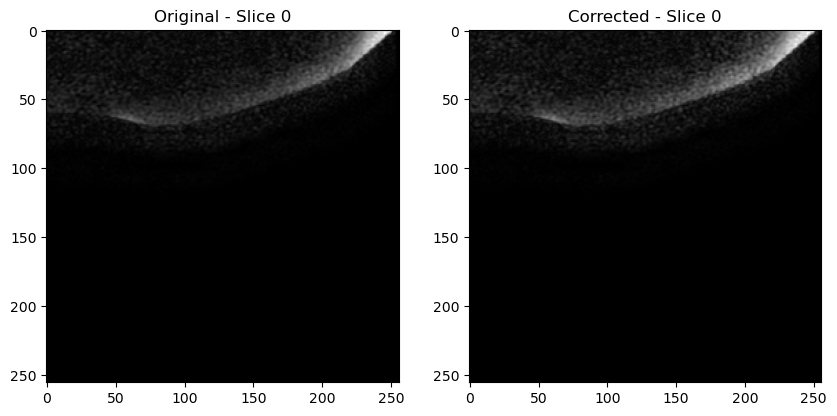

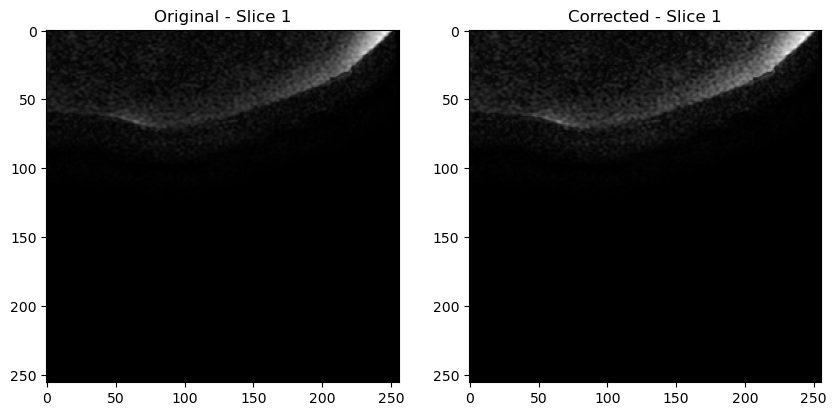

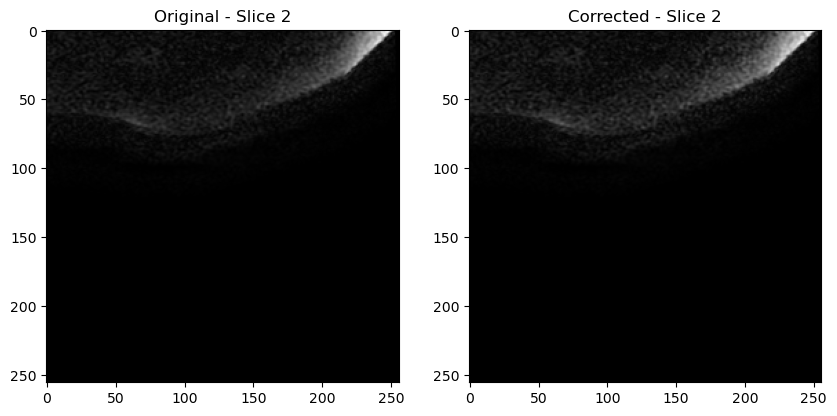

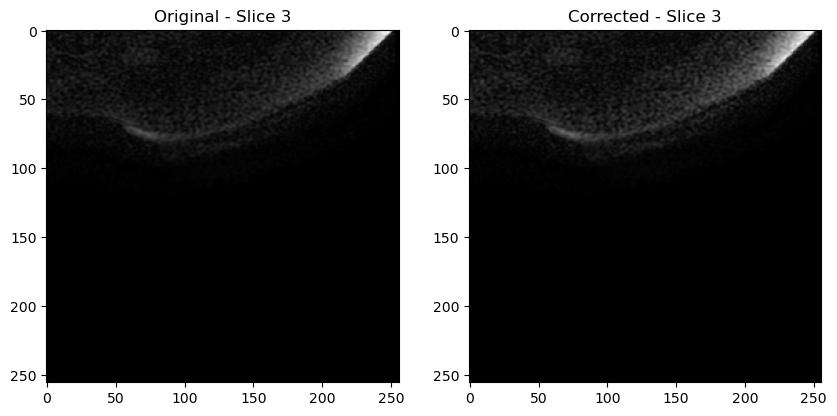

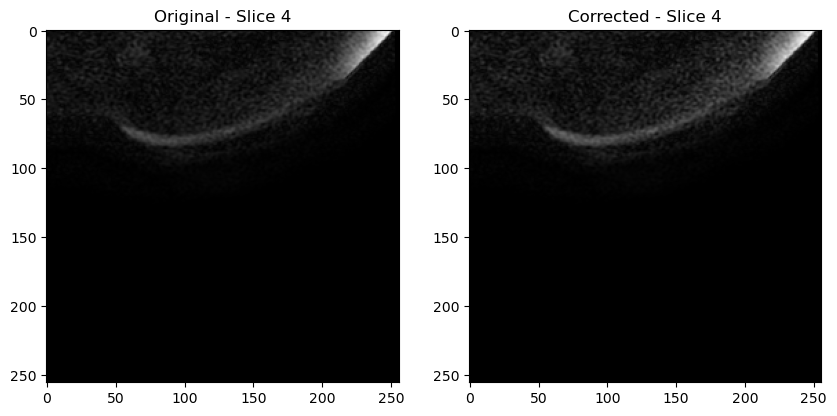

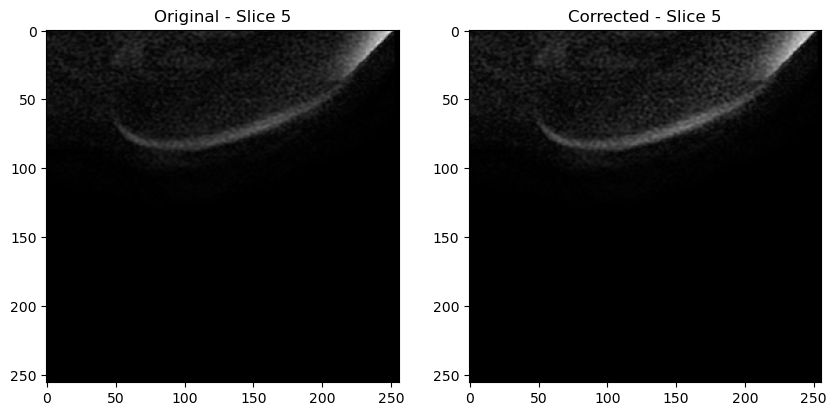

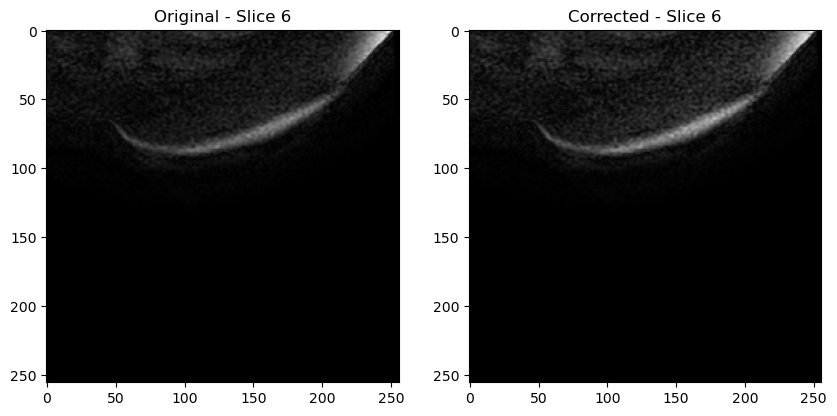

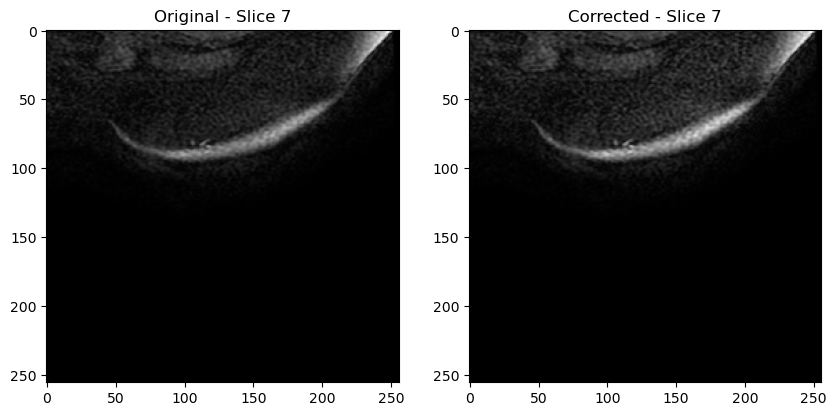

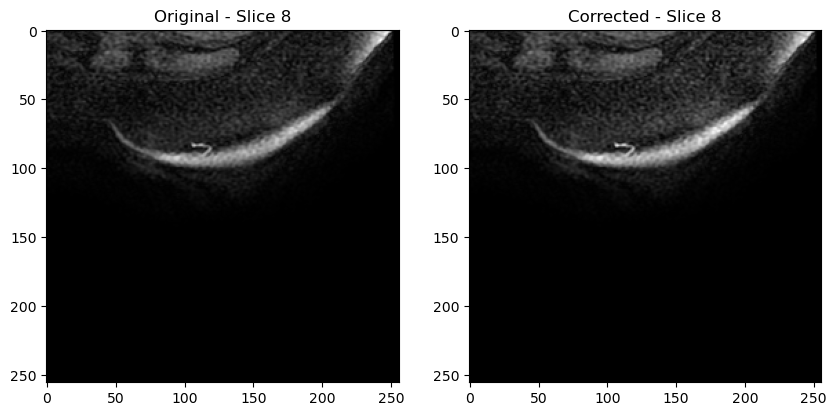

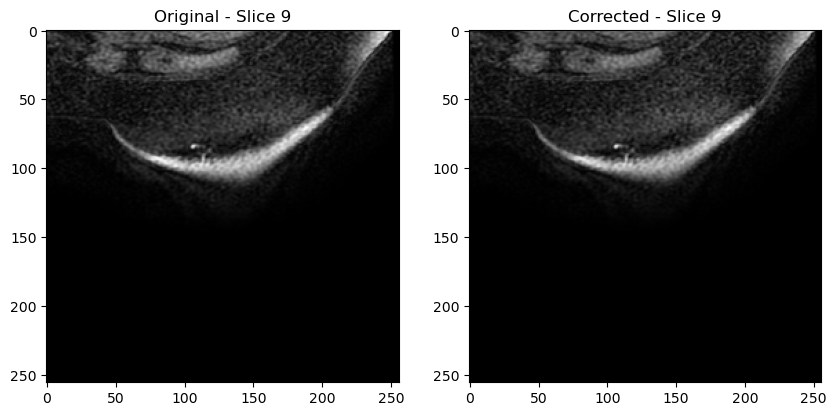

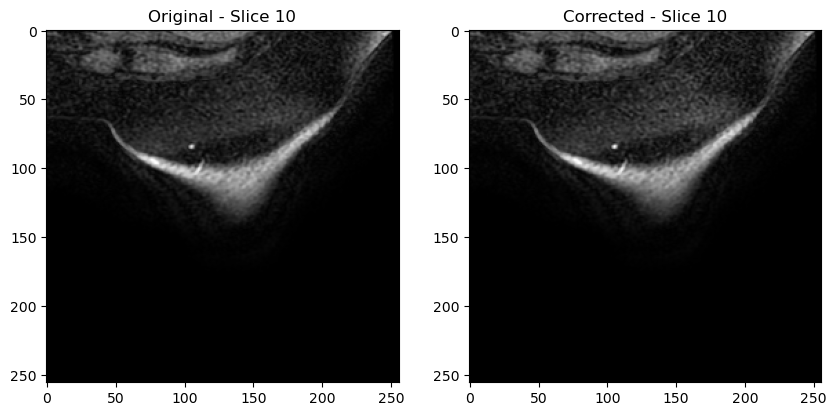

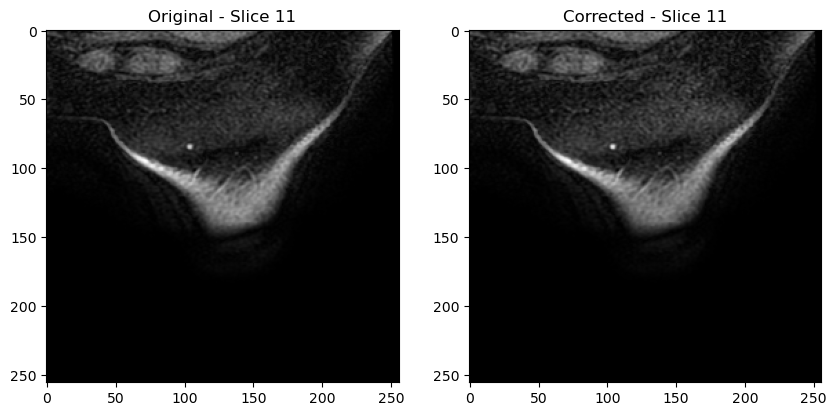

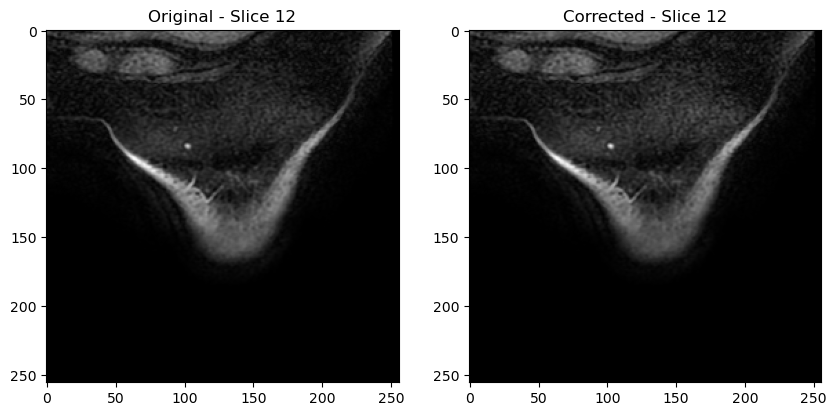

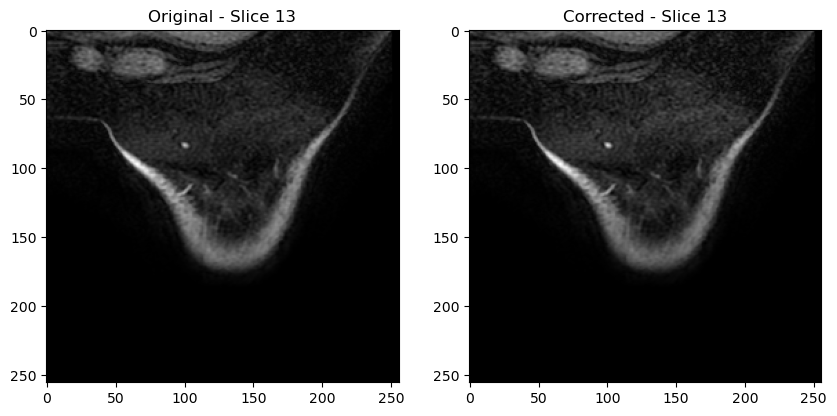

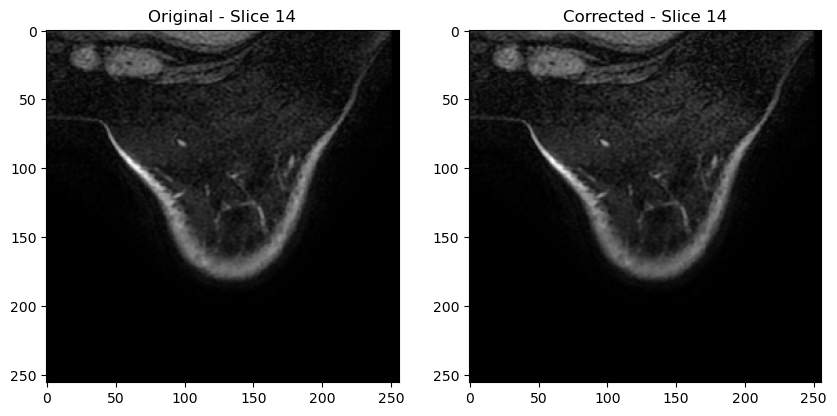

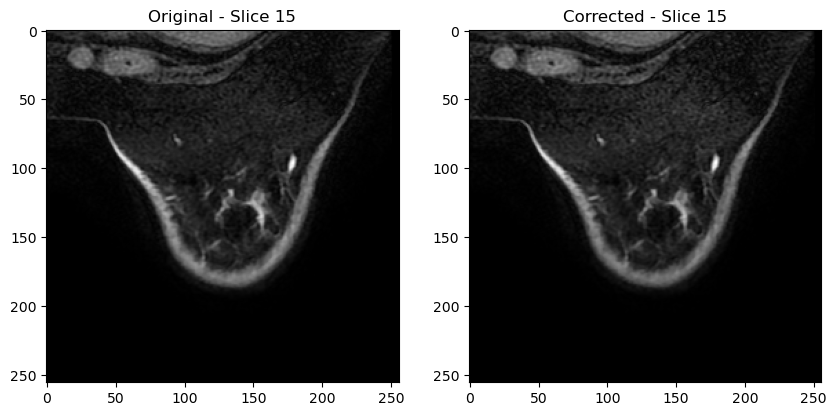

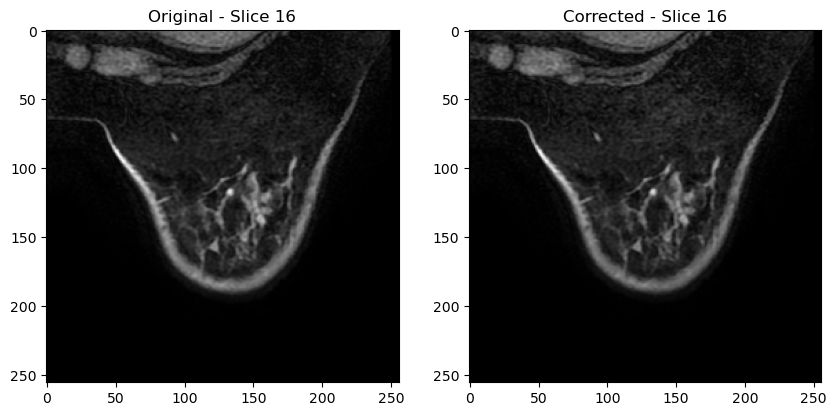

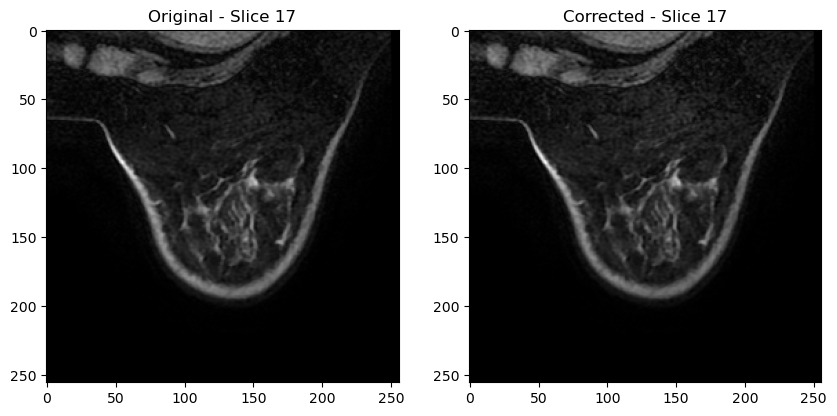

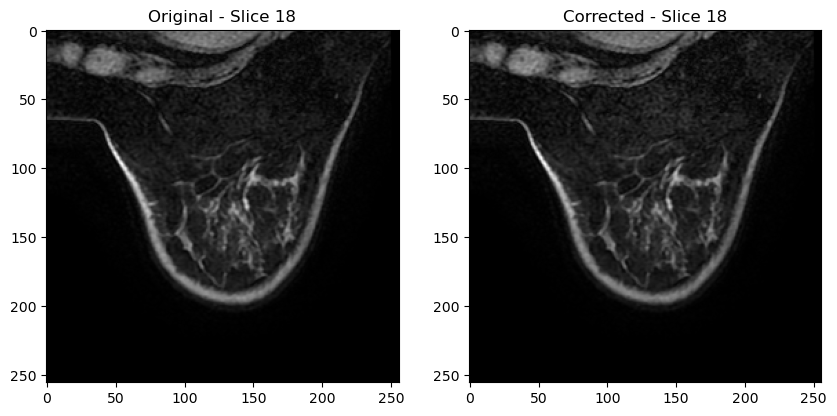

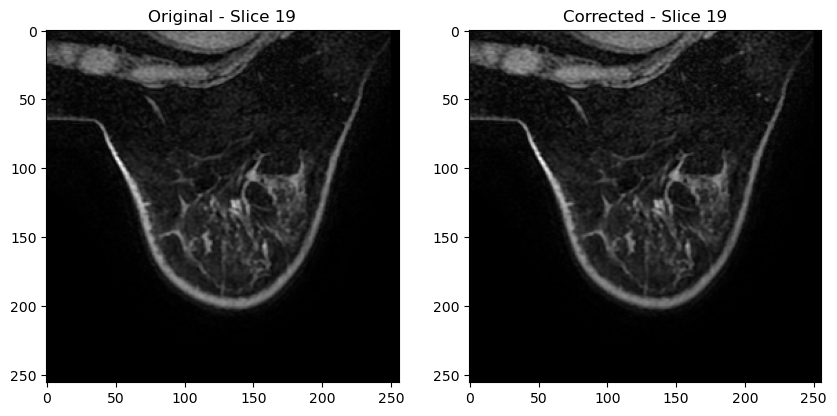

In [22]:
# Load NIfTI images
input_image = sitk.ReadImage(nifti_output_path)
corrected_image = sitk.ReadImage(bias_corr_path)

# Convert to NumPy arrays
original_array = sitk.GetArrayFromImage(input_image)
corrected_array = sitk.GetArrayFromImage(corrected_image)

# Show only the first 20 slices (max is 640)
num_slices = min(20, original_array.shape[0])

# Plot slices
for slice_idx in range(num_slices):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    ax[0].imshow(original_array[slice_idx], cmap="gray")
    ax[0].set_title(f"Original - Slice {slice_idx}")

    ax[1].imshow(corrected_array[slice_idx], cmap="gray")
    ax[1].set_title(f"Corrected - Slice {slice_idx}")

    plt.show()

# Load in image and segmentation

In [ ]:
# Path to the SEG file
# segmentation_file_path = Path("../../rawdata/{DATASET_NAME}/ISPY2-100899/10-26-2002-100899T0-ISPY2MRIT0-88595/51900.000000-ISPY2 VOLSER uni-lateral cropped Analysis Mask-78091/1-1.dcm")
segmentation_file_path = Path(f"../../rawdata/{DATASET_NAME}/ISPY2-100899/10-26-2002-100899T0-ISPY2MRIT0-88595/51900.000000-ISPY2 VOLSER uni-lateral cropped Analysis Mask-78091/1-1.dcm")
# Load the segmentation file (for SEG format)
# This returns a dictionary of segmentation images, with ROI names as keys and image objects as values
seg_image_dict = loadSegmentation(segmentation_file_path, modality='SEG')

# Get the segmentation image for the specific ROI of interest
# Flatten the image if it has extra dimensions, making it 3D
seg_image = flattenImage(seg_image_dict["VOLSER Analysis Mask"])

# TODO: Check if the output image size matches the segmentation image size
# Use the GETSIZE method for seg_image to verify this
#seg_image_size = seg_image.GETSIZE()
print("Image size:", seg_image.GetSize())

# Print available metadata keys
# metadata_keys = seg_image.GetMetaDataKeys()
# print("Image metadata keys:", metadata_keys)

# If you want to print actual metadata for a specific key
for key in metadata_keys:
    print(f"{key}: {seg_image.GetMetaData(key)}")

Image size: (256, 256, 80)
Image spacing: (1.0, 1.0, 1.0)
Image origin: (0.0, 0.0, 0.0)
Image direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Image metadata keys: ()


## Extract Radiomic Features

In [ ]:
# Pick which config settings to use for PyRadiomics feature extraction
pyradiomics_param_file_path = "../config/default_pyradiomics.yaml"

# Run PyRadiomics feature extraction with REAII function
radiomic_features_dict = singleRadiomicFeatureExtraction(output_image, seg_image, pyradiomics_param_file_path, randomSeed=10)

# Convert to dataframe
rad_features_df = pd.DataFrame.from_dict(radiomic_features_dict, orient="index").transpose()


# Save out the results of the feature extraction

In [ ]:
save_radiomics_path = Path("results/4D-Lung/readii_radiomic_features.csv")
save_radiomics_path.parent.mkdir(parents=True, exist_ok=True)

rad_features_df.to_csv(save_radiomics_path, index=False)